# Test for Kuffman
## Xiaonan Wang
## 24Jun2020

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import os
import smqpp
import re
import anndata
from mpl_toolkits.mplot3d import Axes3D

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.5.0 anndata==0.7.1 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.7.0


In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
cdict = {'red': ((0.0, 0.0, 0.0),
                 (0.1, 0.5, 0.5),
                 (0.2, 0.0, 0.0),
                 (0.4, 0.2, 0.2),
                 (0.6, 0.0, 0.0),
                 (0.8, 1.0, 1.0),
                 (1.0, 1.0, 1.0)),
        'green':((0.0, 0.0, 0.0),
                 (0.1, 0.0, 0.0),
                 (0.2, 0.0, 0.0),
                 (0.4, 1.0, 1.0),
                 (0.6, 1.0, 1.0),
                 (0.8, 1.0, 1.0),
                 (1.0, 0.0, 0.0)),
        'blue': ((0.0, 0.0, 0.0),
                 (0.1, 0.5, 0.5),
                 (0.2, 1.0, 1.0),
                 (0.4, 1.0, 1.0),
                 (0.6, 0.0, 0.0),
                 (0.8, 0.0, 0.0),
                 (1.0, 0.0, 0.0))}

def plot_3d(adata_ref, obs_key, adata_new=None, obsm_key='X_diffmap', ncols=4,figsize=(6,6), alpha=0.5, azim=250,elev=30, markersize=1,components=[1,2,3], cmap=None):
    nkey = len(obs_key)
    if nkey <=4:
        ncols = nkey
    nrows = int(np.ceil((nkey)/ncols))
    fig = plt.figure(figsize=figsize)
    for nk in range(nkey):
        k = obs_key[nk]
        ax = fig.add_subplot(nrows, ncols, nk+1, projection='3d')
        ax.view_init(azim=azim, elev=elev)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        
        if adata_new is None:
            adata = adata_ref.copy()
        else:
            adata = adata_new.copy()
            dm_ref = adata_ref.obsm[obsm_key]
            ax.plot(dm_ref[:,components[0]],dm_ref[:,components[1]],dm_ref[:,components[2]], '.', markersize=markersize, c='#d3d3d3', label = 'Ref_data', alpha =alpha)

        dm_new = adata.obsm[obsm_key]
        obs_term = adata.obs[k]
        if obs_term.dtype == 'float32' or obs_term.dtype == int or obs_term.dtype == 'float':
            if cmap is None:
                cmap = LinearSegmentedColormap('my_colormap',cdict,256) 
            #print(np.array(obs_term.values))
            conti_fig = ax.scatter(dm_new[:,components[0]],dm_new[:,components[1]],dm_new[:,components[2]], '.', s=markersize, c=np.array(obs_term.values), cmap=cmap, alpha =alpha)
            fig.colorbar(conti_fig, shrink=0.5)
            
        
        else:
            obs_term = obs_term.astype('category')
            cats = obs_term.cat.categories
            if k+'_colors' in adata.uns_keys():
                color_pal = adata.uns[k+'_colors']
            else:
                color_pal = sc.pl.palettes.default_20[0:len(cats)]
            for i in range(len(cats)):
                #print(cats[i])
                idx = obs_term==cats[i]
                ax.plot(dm_new[idx,components[0]],dm_new[idx,components[1]],dm_new[idx,components[2]], '.', markersize=markersize, c=color_pal[i], label = cats[i], alpha =alpha)

            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.tight_layout()

In [29]:
wdir = '/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Carys/'
kuffman_raw = sc.read(wdir+'MPB1234/write/kuffman_raw_MPB.h5ad')
kuffman_raw.var_names_make_unique()
print('kuffmanData shape: '+ str(kuffman_raw.shape))
MPBD0_raw = sc.read(wdir+'MPB1234/write/MPB1234_raw_Day0.h5ad')
MPBD0_raw.var_names_make_unique()
print('MPBD0 shape: '+ str(MPBD0_raw.shape))
BMD0_raw = sc.read(wdir+'BM789/write/BM789_raw_Day0.h5ad')
BMD0_raw.var_names_make_unique()
print('BMD0 shape: '+ str(BMD0_raw.shape))

kuffmanData shape: (1109, 28720)
MPBD0 shape: (598, 65988)
BMD0 shape: (228, 65988)


In [13]:
GOL = np.intersect1d(kuffman_raw.var_names, MPBD0_raw.var_names)
print(len(GOL))

21427


In [30]:
kuffman_raw = kuffman_raw[:, GOL].copy()
MPBD0_raw = MPBD0_raw[:, GOL].copy()
BMD0_raw = BMD0_raw[:, GOL].copy()

In [31]:
kuffman_raw.obs['Batch'] = kuffmanData.obs['Donor']

In [16]:
adata = kuffman_raw.concatenate(MPBD0_raw, BMD0_raw)

filtered out 83 genes that are detected in less than 1 cells
Calculate SF for genes:
Filtered matrix shape: (1935, 12)
Number of valid means:12


/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)
... storing 'Batch' as categorical
... storing 'CI_annotation_of_index' as categorical
... storing 'CRI_identifier' as categorical
... storing 'CRI_run' as categorical
... storing 'Cell_Type' as categorical
... storing 'Cell_type_general' as categorical
... storing 'Cell_type_subtype' as categorical
... storing 'Condition' as categorical
... storing 'Cycling' as categorical
... storing 'DCA_split' as categorical
... storing 'Day' as categorical
... storing 'Details' as categorical
... storing 'Donor' as categorical
... storing 'FACs_index_data' as categorical
... storing 'Gottgens_ID_RBGxxx' as categorical
... storing 'ID' as categorical
... storing 'Index' as categorical
... storing 'Index_name_in_library_Set' as categorical
... storing 'Owner' as categorical


MeanForFit:  5
6131
Length of HVGs: 3301


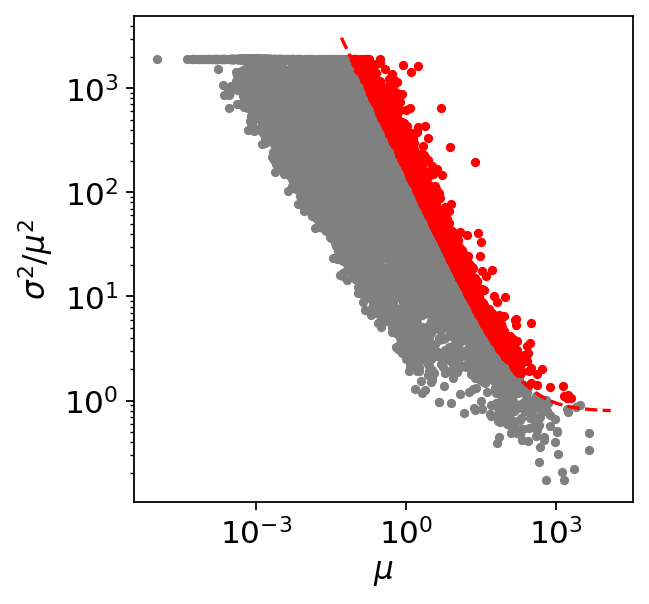

In [17]:
sc.pp.filter_genes(adata, min_cells=1)
adata.var_names_make_unique()
# normalisation
smqpp.normalise_data(adata)
adata.raw = adata
smqpp.tech_var(adata, useERCC=False, meanForFit=5) 
smqpp.plot_tech_var(adata)
adata.write('./write/Kuffmantest/kuffman_MPBd0_BMd0_lognorm.h5ad')

In [18]:
from scipy.sparse import csr_matrix
adata.X = csr_matrix(adata.X)

In [19]:
adata.obs['Batch'].value_counts()

mPB-2    426
mPB-3    372
mPB-4    311
B1       244
B2       138
B4       123
B3        93
S09       89
S07       74
S08       65
Name: Batch, dtype: int64

In [20]:
sc.pp.combat(adata, key='Batch')

Standardizing Data across genes.

Found 10 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments



/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


Adjusting data



In [21]:
adata.obs_names= [x[:-2] for x in adata.obs_names]

In [22]:
adata.write('./write/Kuffmantest/kuffman_MPBd0_BMd0_lognorm_combatBC.h5ad')

# Destiny R

In [185]:
adata = sc.read('./write/Kuffmantest/kuffman_MPBd0_BMd0_lognorm_combatBC.h5ad')

In [186]:
adata = adata[:,adata.uns['varGenes']['genes']['highVar']].copy()

In [25]:
kuffman_bcD = adata[adata.obs['batch'] == '0', ].X.toarray()
MPB_bcD = adata[adata.obs['batch'] == '1', ].X.toarray()
BM_bcD = adata[adata.obs['batch'] == '2', ].X.toarray()

In [26]:
%reload_ext rpy2.ipython

In [28]:
%%R -i kuffman_bcD -i MPB_bcD -i BM_bcD
suppressMessages(library(destiny))
print("Calculating Diffusion Map Kuffman")
dm_kuffman = DiffusionMap(kuffman_bcD, distance="cosine")
saveRDS(dm_kuffman, file="./Datafiles/Kuffmantest/dm_kuffman.rds")
print("Calculating Projection MPB")
MPB_proj = dm_predict(dm_kuffman, MPB_bcD)
saveRDS(MPB_proj, file="./Datafiles/Kuffmantest/MPB_proj.rds")
print("Calculating Projection BM")
BM_proj = dm_predict(dm_kuffman, BM_bcD)
saveRDS(BM_proj, file="./Datafiles/Kuffmantest/BM_proj.rds")
write.table(dm_kuffman@eigenvectors, "./Datafiles/Kuffmantest/X_DM_CB.csv", quote=F, row.names=T, col.names=T, sep=",")
write.table(as.matrix(MPB_proj), "./Datafiles/Kuffmantest/X_DM_MPB.csv", quote=F, row.names=T, col.names=T, sep=",")
write.table(as.matrix(BM_proj), "./Datafiles/Kuffmantest/X_DM_BM.csv", quote=F, row.names=T, col.names=T, sep=",")

print("Calculating Diffusion Map all")
dm_all = DiffusionMap(rbind(kuffman_bcD, MPB_bcD, BM_bcD), distance="cosine")
saveRDS(dm_all, file="./Datafiles/Kuffmantest/dm_all.rds")
write.table(dm_all@eigenvectors, "./Datafiles/Kuffmantest/X_DM_R.csv", quote=F, row.names=T, col.names=T, sep=",")

[1] "Calculating Diffusion Map Kuffman"
[1] "Calculating Projection MPB"
[1] "Calculating Projection BM"
[1] "Calculating Diffusion Map all"


In [59]:
kuffman_processed = sc.read(wdir+'/MPB1234/write/kuffman_processed_MPB.h5ad')
MPBD0_processed = sc.read(wdir+'/MPB1234/write/MPB1234_Day0_processed_regressout_ngene_BC.h5ad')
BMD0_processed = sc.read(wdir+'/BM789/write/BM789_Day0_processed_regressout_ngene_BC.h5ad')

In [187]:
kuffmanData = adata[adata.obs['batch'] == '0'].copy()
kuffmanData.obs = kuffman_processed.obs
print(kuffmanData.shape)
MPBdata = adata[adata.obs['batch'] == '1'].copy()
MPBdata.obs = MPBD0_processed.obs
print(MPBdata.shape)
BMdata = adata[adata.obs['batch'] == '2'].copy()
BMdata.obs = BMD0_processed.obs
print(BMdata.shape)

(1109, 3301)
(598, 3301)
(228, 3301)


In [33]:
DM_co = pd.read_csv('./Datafiles/Kuffmantest/X_DM_R.csv', index_col=0, header=0)

In [61]:
adata.obsm['X_diffmap'] = np.array(DM_co)

In [188]:
kuffmanData.obsm['X_diffmap'] = np.array(DM_co.iloc[0:1109,:])
MPBdata.obsm['X_diffmap'] = np.array(DM_co.iloc[1109:1707,:])
BMdata.obsm['X_diffmap'] = np.array(DM_co.iloc[1707:1935,:])

In [63]:
kuffmanData.write('./write/Kuffmantest/CBdata_combat.h5ad')
MPBdata.write('./write/Kuffmantest/MPBdata_combat.h5ad')
BMdata.write('./write/Kuffmantest/BMdata_combat.h5ad')
adata.write('./write/Kuffmantest/Kuffman_MPBD0_BMD0_lognorm_combatBC_processed.h5ad') 

In [189]:
kuffmanData.uns['Cycling_colors'] = ['#8b0000', '#d3d3d3'] 

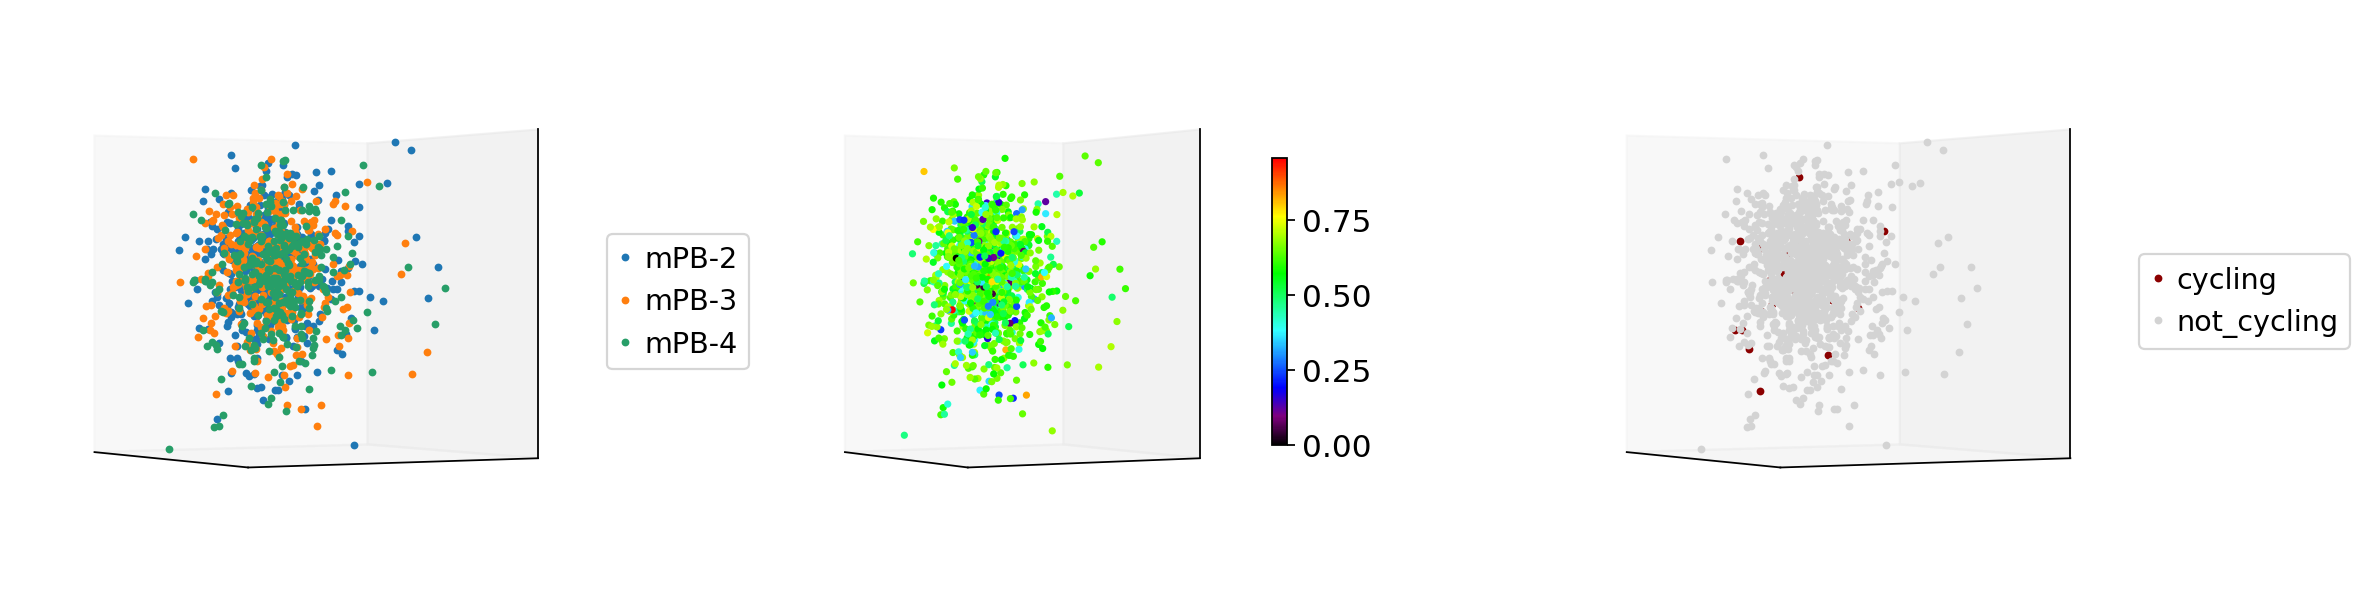

In [203]:
plot_3d(kuffmanData, ['Donor', 'dpt_pseudotime_kenny', 'Cycling'], figsize=(15,4), azim=150,elev=0, components=[0,1,2], alpha=1, markersize=5)

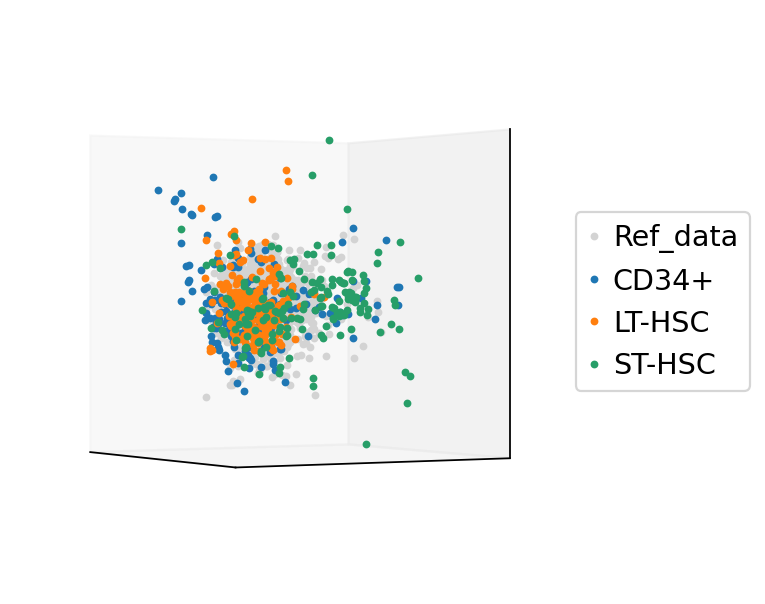

In [202]:
plot_3d(kuffmanData, ['Cell_Type'], MPBdata, figsize=(5,4), azim=150,elev=0, components=[0, 1,2], alpha=1, markersize=5)

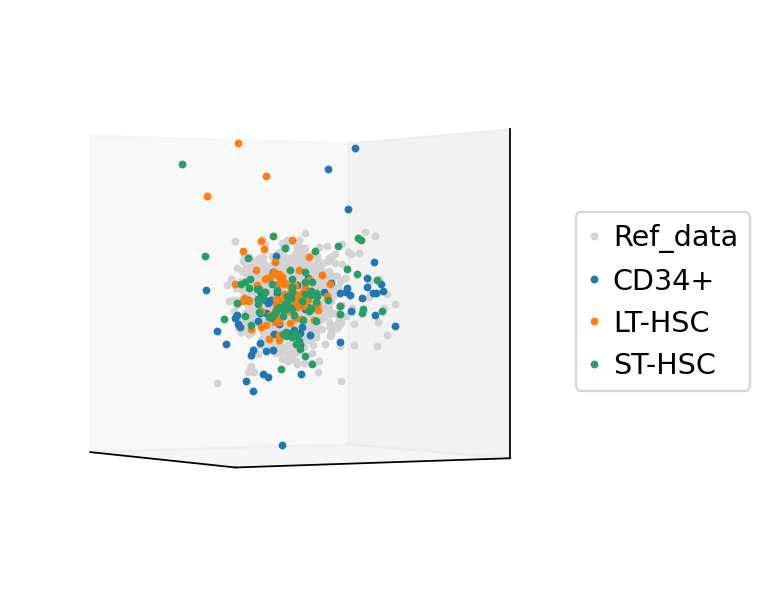

In [204]:
plot_3d(kuffmanData, ['Cell_Type'], BMdata, figsize=(5,4), azim=150,elev=0, components=[0,1,2], alpha=1, markersize=5)

## Projection

In [89]:
kuffmanData.obsm['X_diffmap'] = np.array(pd.read_csv('./Datafiles/Kuffmantest/X_DM_CB.csv', index_col=0, header=0))
MPBdata.obsm['X_diffmap'] = np.array(pd.read_csv('./Datafiles/Kuffmantest/X_DM_MPB.csv', index_col=0, header=0))
BMdata.obsm['X_diffmap'] = np.array(pd.read_csv('./Datafiles/Kuffmantest/X_DM_BM.csv', index_col=0, header=0))

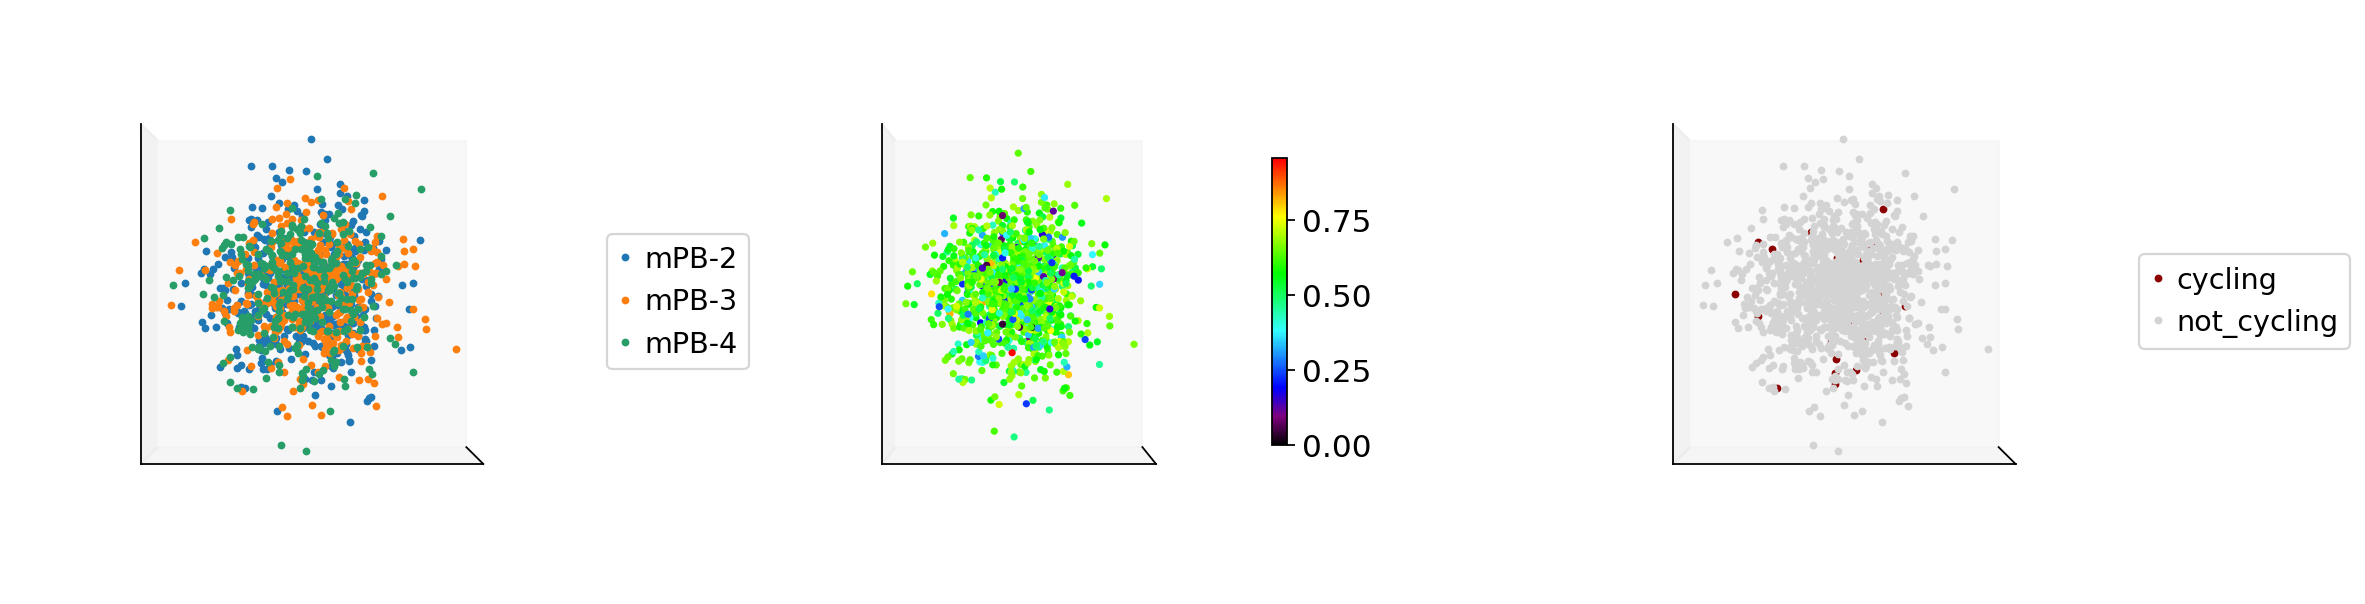

In [93]:
plot_3d(kuffmanData, ['Donor', 'dpt_pseudotime_kenny', 'Cycling'], figsize=(15,4), azim=0,elev=0, components=[0,1,2], alpha=1, markersize=5)

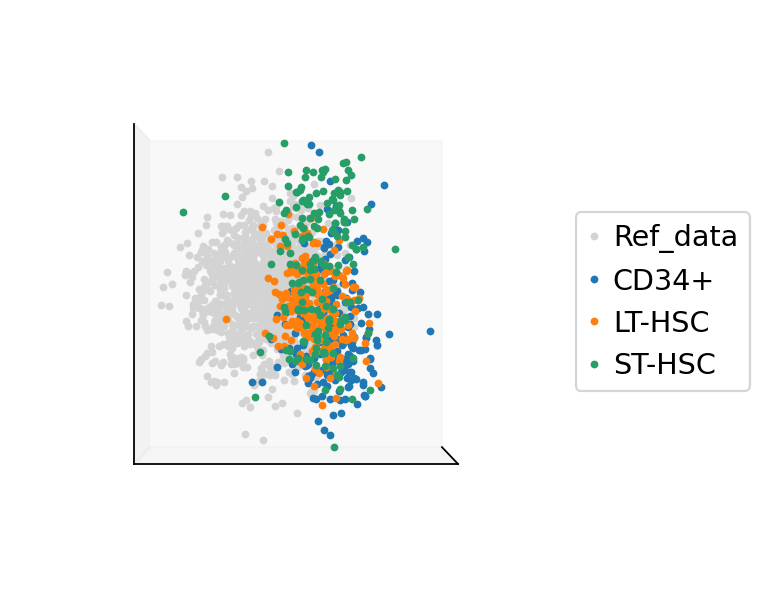

In [90]:
plot_3d(kuffmanData, ['Cell_Type'], MPBdata, figsize=(5,4), azim=0,elev=0, components=[0,1,2], alpha=1, markersize=5)

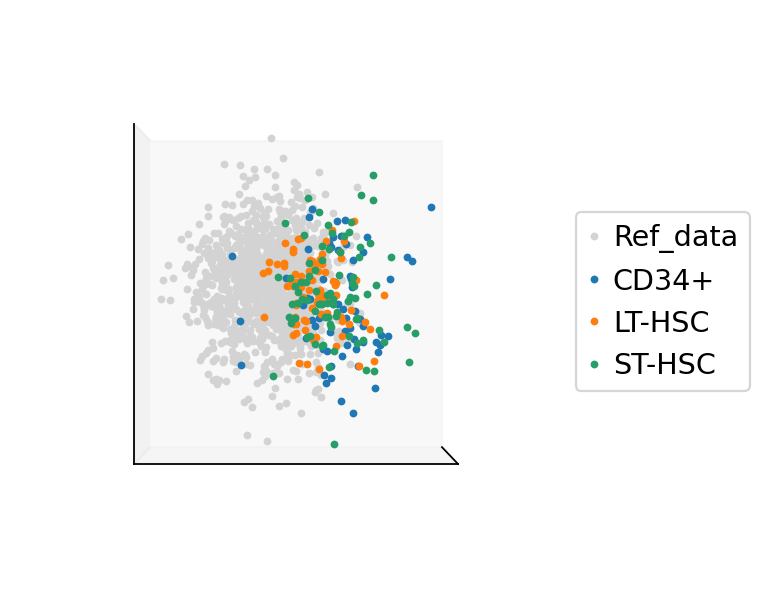

In [91]:
plot_3d(kuffmanData, ['Cell_Type'], BMdata, figsize=(5,4), azim=0,elev=0, components=[0,1,2], alpha=1, markersize=5)

# Combat scanpy

In [162]:
adata = sc.read('./write/Kuffmantest/kuffman_MPBd0_BMd0_lognorm_combatBC.h5ad')

In [163]:
adata = adata[:,adata.uns['varGenes']['genes']['highVar']].copy()

In [164]:
# Scale the data for PCA then do other DR
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)
sc.tl.diffmap(adata)

computing PCA
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9338465  0.9150551  0.87268144 0.84290195 0.8407689
     0.8250946  0.7780146  0.76280946 0.7531705  0.7508131  0.7446387
     0.74131685 0.73755455 0.7358871 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


In [165]:
kuffmanData = adata[adata.obs['batch'] == '0'].copy()
kuffmanData.obs = kuffman_processed.obs
print(kuffmanData.shape)
MPBdata = adata[adata.obs['batch'] == '1'].copy()
MPBdata.obs = MPBD0_processed.obs
print(MPBdata.shape)
BMdata = adata[adata.obs['batch'] == '2'].copy()
BMdata.obs = BMD0_processed.obs
print(BMdata.shape)

(1109, 3301)
(598, 3301)
(228, 3301)


In [166]:
kuffmanData.uns['Cycling_colors'] = ['#8b0000', '#d3d3d3'] 

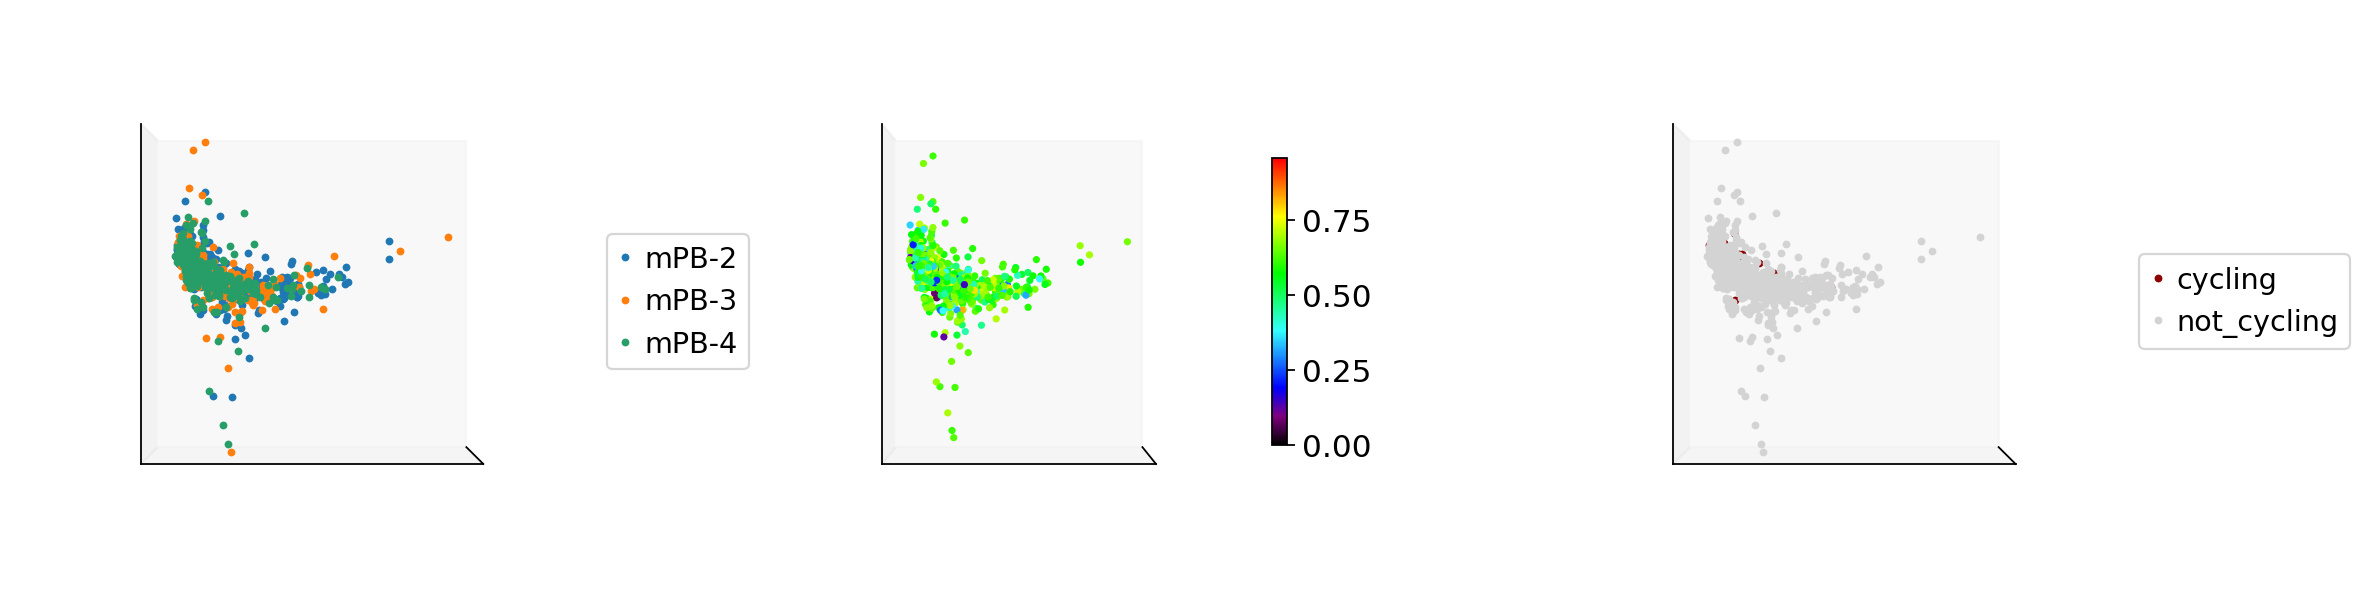

In [180]:
plot_3d(kuffmanData, ['Donor', 'dpt_pseudotime_kenny', 'Cycling'], figsize=(15,4), azim=0,elev=0, components=[1,2,3], alpha=1, markersize=5)

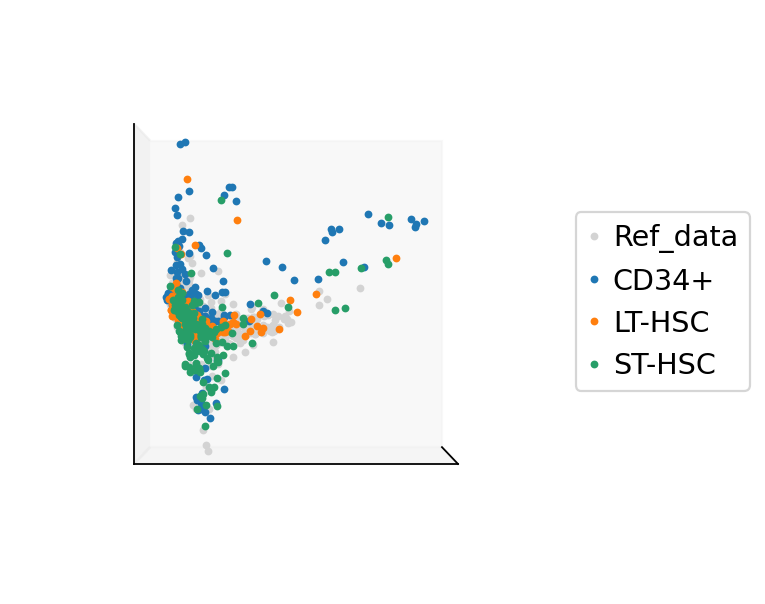

In [184]:
plot_3d(kuffmanData, ['Cell_Type'], MPBdata, figsize=(5,4), azim=0,elev=0, components=[1,2,3], alpha=1, markersize=5)

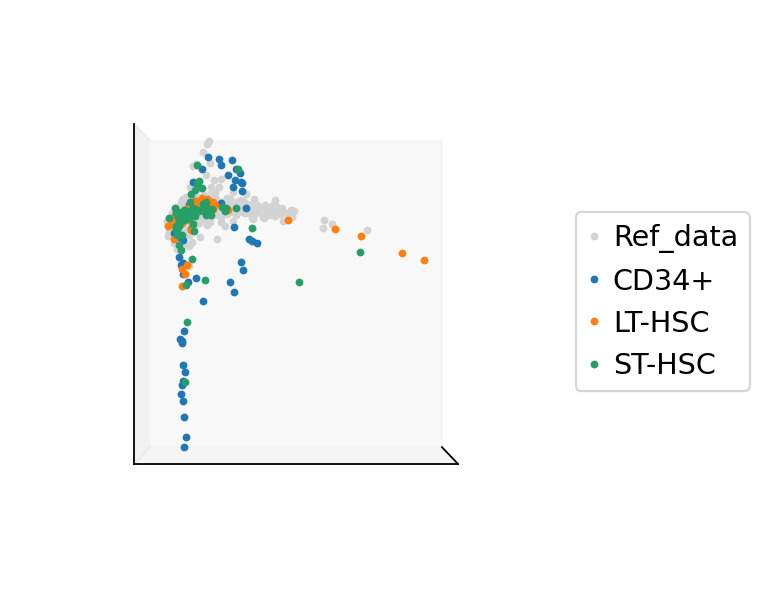

In [111]:
plot_3d(kuffmanData, ['Cell_Type'], BMdata, figsize=(5,4), azim=0,elev=0, components=[1,2,3], alpha=1, markersize=5)

# FastMNN scanpy

In [139]:
adata = sc.read('./write/Kuffmantest/kuffman_MPBd0_BMd0_lognorm.h5ad')

In [140]:
adata.obs_names= [x[:-2] for x in adata.obs_names]

In [141]:
adata = adata[:,adata.uns['varGenes']['genes']['highVar']].copy()

In [142]:
# Scale the data for PCA
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:00)


In [143]:
adata.obs['Batch'].value_counts()

mPB-2    426
mPB-3    372
mPB-4    311
B1       244
B2       138
B4       123
B3        93
S09       89
S07       74
S08       65
Name: Batch, dtype: int64

In [144]:
adata.shape

(1935, 3301)

In [145]:
X_pca = adata.obsm['X_pca']
idx0 = adata.obs['Batch'] == 'mPB-2'
print(sum(idx0))
idx1 = adata.obs['Batch'] == 'mPB-3'
print(sum(idx1))
idx2 = adata.obs['Batch'] == 'mPB-4'
print(sum(idx2))
idx3 = adata.obs['Batch'] == 'B1'
print(sum(idx3))
idx4 = adata.obs['Batch'] == 'B2'
print(sum(idx4))
idx5 = adata.obs['Batch'] == 'B3'
print(sum(idx5))
idx6 = adata.obs['Batch'] == 'B4'
print(sum(idx6))
idx7 = adata.obs['Batch'] == 'S07'
print(sum(idx7))
idx8 = adata.obs['Batch'] == 'S08'
print(sum(idx8))
idx9 = adata.obs['Batch'] == 'S09'
print(sum(idx9))
pca0 = pd.DataFrame(X_pca[idx0])
print(pca0.shape)
pca1 = pd.DataFrame(X_pca[idx1])
print(pca1.shape)
pca2 = pd.DataFrame(X_pca[idx2])
print(pca2.shape)
pca3 = pd.DataFrame(X_pca[idx3])
print(pca3.shape)
pca4 = pd.DataFrame(X_pca[idx4])
print(pca4.shape)
pca5 = pd.DataFrame(X_pca[idx5])
print(pca5.shape)
pca6 = pd.DataFrame(X_pca[idx6])
print(pca6.shape)
pca7 = pd.DataFrame(X_pca[idx7])
print(pca7.shape)
pca8 = pd.DataFrame(X_pca[idx8])
print(pca8.shape)
pca9 = pd.DataFrame(X_pca[idx9])
print(pca9.shape)

426
372
311
244
138
93
123
74
65
89
(426, 50)
(372, 50)
(311, 50)
(244, 50)
(138, 50)
(93, 50)
(123, 50)
(74, 50)
(65, 50)
(89, 50)


In [146]:
%reload_ext rpy2.ipython

In [147]:
%%R -i pca0 -i pca1 -i pca2 -i pca3 -i pca4 -i pca5 -i pca6 -i pca7 -i pca8 -i pca9 -o odf
suppressMessages(library("batchelor"))
odf = reducedMNN(data.matrix(pca0), data.matrix(pca1), data.matrix(pca2),data.matrix(pca3),data.matrix(pca4),data.matrix(pca5),data.matrix(pca6),data.matrix(pca7),data.matrix(pca8),data.matrix(pca9),
                      BPPARAM=MulticoreParam(detectCores()))
odf = data.frame(odf$corrected)

In [148]:
odf.shape

(1935, 50)

In [149]:
adata.shape

(1935, 3301)

In [150]:
CNs = np.concatenate([adata.obs_names[x] for x in [idx0, idx1, idx2, idx3, idx4, idx5, idx6, idx7, idx8, idx9]])
adata = adata[CNs,:].copy()
adata.obsm['X_pca'] = odf.values

In [151]:
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.diffmap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9663245  0.93836415 0.90001404 0.89087874 0.86185324
     0.8423518  0.8201344  0.78906673 0.7720876  0.7667899  0.76183665
     0.7538041  0.75224334 0.7445283 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


In [153]:
kuffmanData = adata[adata.obs['batch'] == '0'].copy()
kuffmanData.obs = kuffman_processed.obs
print(kuffmanData.shape)
MPBdata = adata[adata.obs['batch'] == '1'].copy()
MPBdata.obs = MPBD0_processed.obs
print(MPBdata.shape)
BMdata = adata[adata.obs['batch'] == '2'].copy()
BMdata.obs = BMD0_processed.obs
print(BMdata.shape)

(1109, 3301)
(598, 3301)
(228, 3301)


In [154]:
kuffmanData.uns['Cycling_colors'] = ['#8b0000', '#d3d3d3'] 

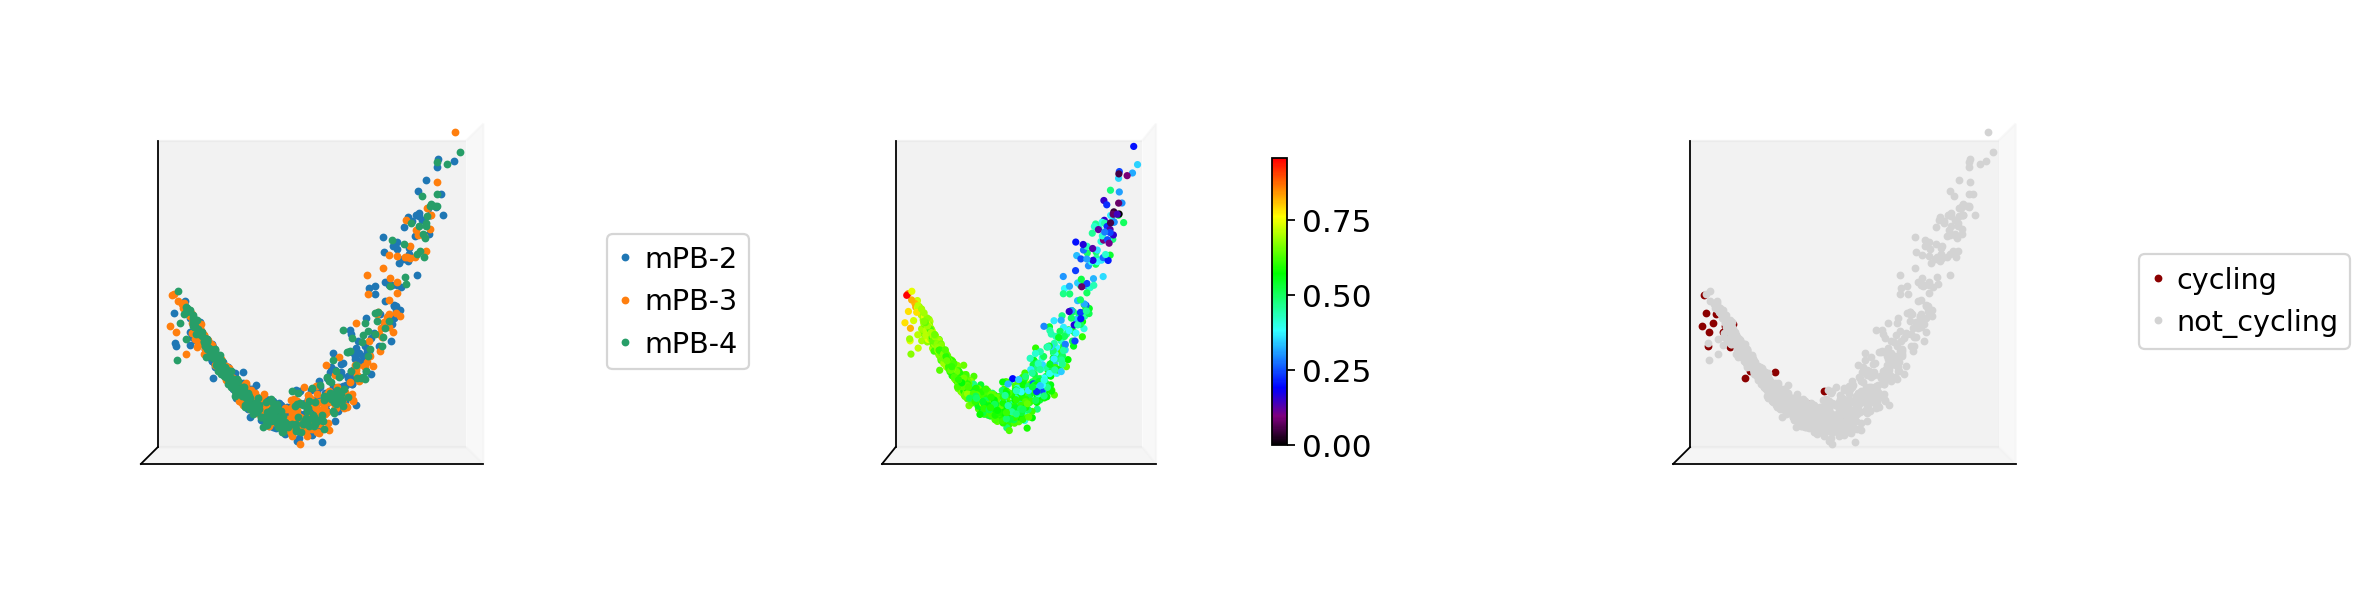

In [159]:
plot_3d(kuffmanData, ['Donor', 'dpt_pseudotime_kenny', 'Cycling'], figsize=(15,4), azim=90,elev=0, components=[1,2,3], alpha=1, markersize=5)

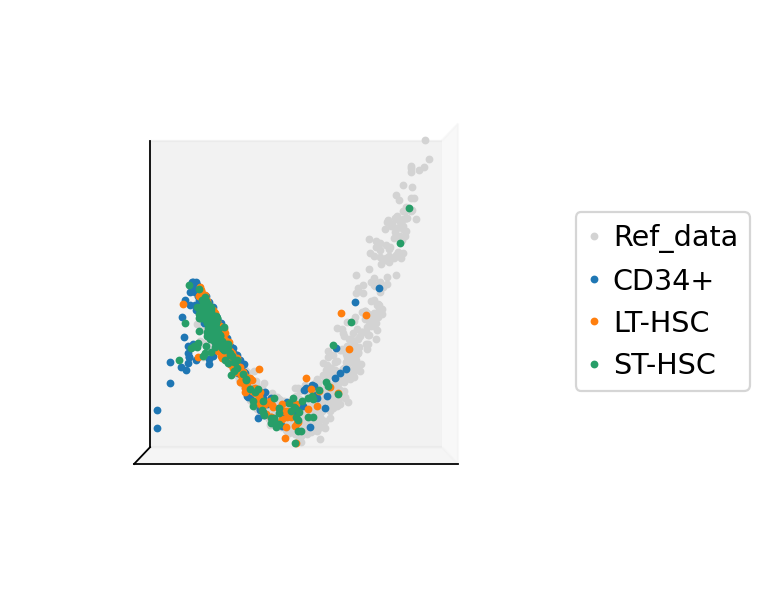

In [160]:
plot_3d(kuffmanData, ['Cell_Type'], MPBdata, figsize=(5,4), azim=90,elev=0, components=[1,2,3], alpha=1, markersize=5)

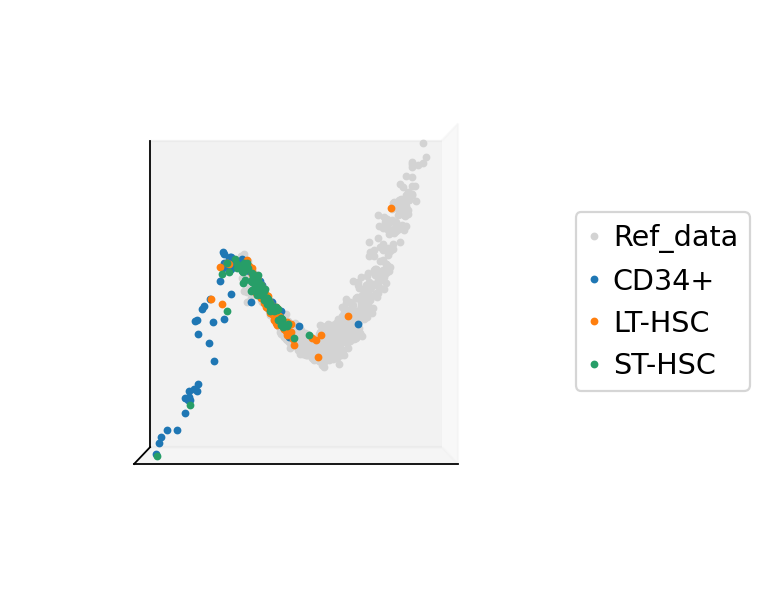

In [161]:
plot_3d(kuffmanData, ['Cell_Type'], BMdata, figsize=(5,4), azim=90,elev=0, components=[1,2,3], alpha=1, markersize=5)